In [1]:
# Argparse
import argparse
opt = argparse.Namespace( # Fake parsed arguments
    seed=3,
    device=-1,
    cuda=False,
    visdom=True
)

# Util
import cdae.util as util
util.init(opt)

# Model
import cdae.models.quadratic2 as quadratic


# Torch
import torch
from torch.autograd import Variable
import torch.optim as optim

# Plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.available
plt.style.use('seaborn-whitegrid')

%matplotlib notebook

# Stats
import scipy.stats

# Generative Model

The true generative model $p$ over latents $k, x$ and observed variables $y$ is:
\begin{align}
    k &\sim \mathrm{Categorical}([2, 10], [0.5, 0.5]) \\\
    x &\sim \mathrm{Normal}(0, 1) \\\
    y &\sim \mathrm{Normal}(f(k, x) ,1)
\end{align}
where $f: \mathbb R^2 \to \mathbb R$ is defined as
\begin{align}
    f(k, x) = a(k + x)^2 + b(k + x) + c.
\end{align}


<IPython.core.display.Javascript object>


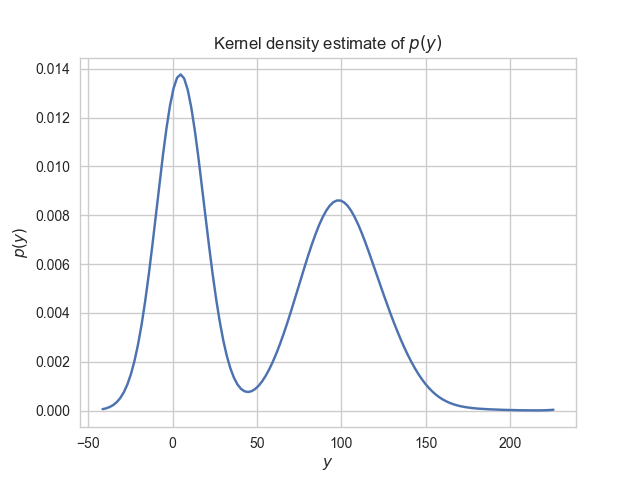

In [2]:
generative_model = quadratic.GenerativeModel(a=1, b=0, c=0)
num_data = 1000
_, _, y = generative_model.sample(num_data)
y = y.squeeze(1).numpy()
fig, ax = plt.subplots()
sns.kdeplot(y, ax=ax)
ax.set_title('Kernel density estimate of $p(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y)$')

# Generative Network

Assume that we actually don't know the form of $f$ and that we want to learn it, i.e. the true model $p$ from a dataset $(y^{(n)})_{n = 1}^N$.
Let's model the family of functions $f$ under consideration as a neural network parameterized by generative weights $\theta$ such that it maps from $\mathbb R^2$ to $\mathbb R$:

<IPython.core.display.Javascript object>


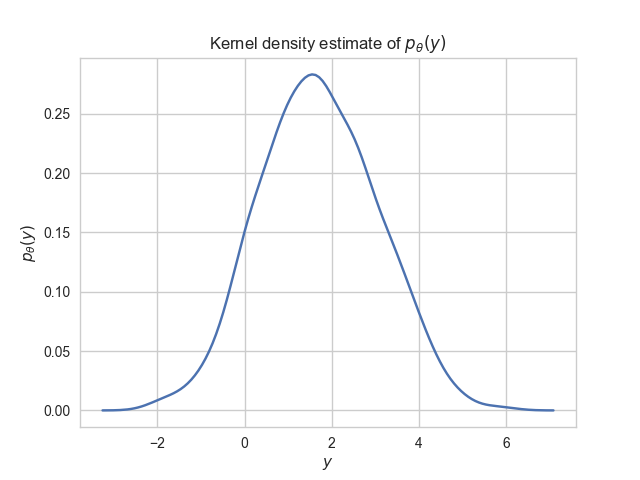

In [3]:
generative_network = quadratic.GenerativeNetwork()
num_data = 1000
_, _, y = generative_network.sample(num_data)
y = y.squeeze(1).numpy()

fig, ax = plt.subplots()
sns.kdeplot(y, ax=ax)
ax.set_title('Kernel density estimate of $p_{\\theta}(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p_{\\theta}(y)$')

# Inference Network

We seek to learn an inference network $q_{\phi}(k, x \lvert y)$ parameterized by $\phi$ which, given $y$ maps to the parameters of the distribution over $(k, x)$, ideally close to the posterior under the true model, $p(k, x \lvert y)$.

Let
\begin{align}
    q_{\phi}(k, x \lvert y) &= q_{\phi}(k \lvert y) q_{\phi}(x \lvert k, y) \\\
    q_{\phi}(k \lvert y) &= \mathrm{Categorical}([2, 5], [\phi_1, \phi_2]) \\\
    q_{\phi}(x \lvert k, y) &= \mathrm{Normal}(\phi_3, \phi_4)
\end{align}
where $\phi = [\phi_1, \dotsc, \phi_4]$ is the output of the inference network.

In [4]:
inference_network = quadratic.InferenceNetwork()
_, _, y_test = generative_model.sample(1)
y_test = generative_model.sample(1)[2][0][0]
y_test

8.594072341918945

<IPython.core.display.Javascript object>


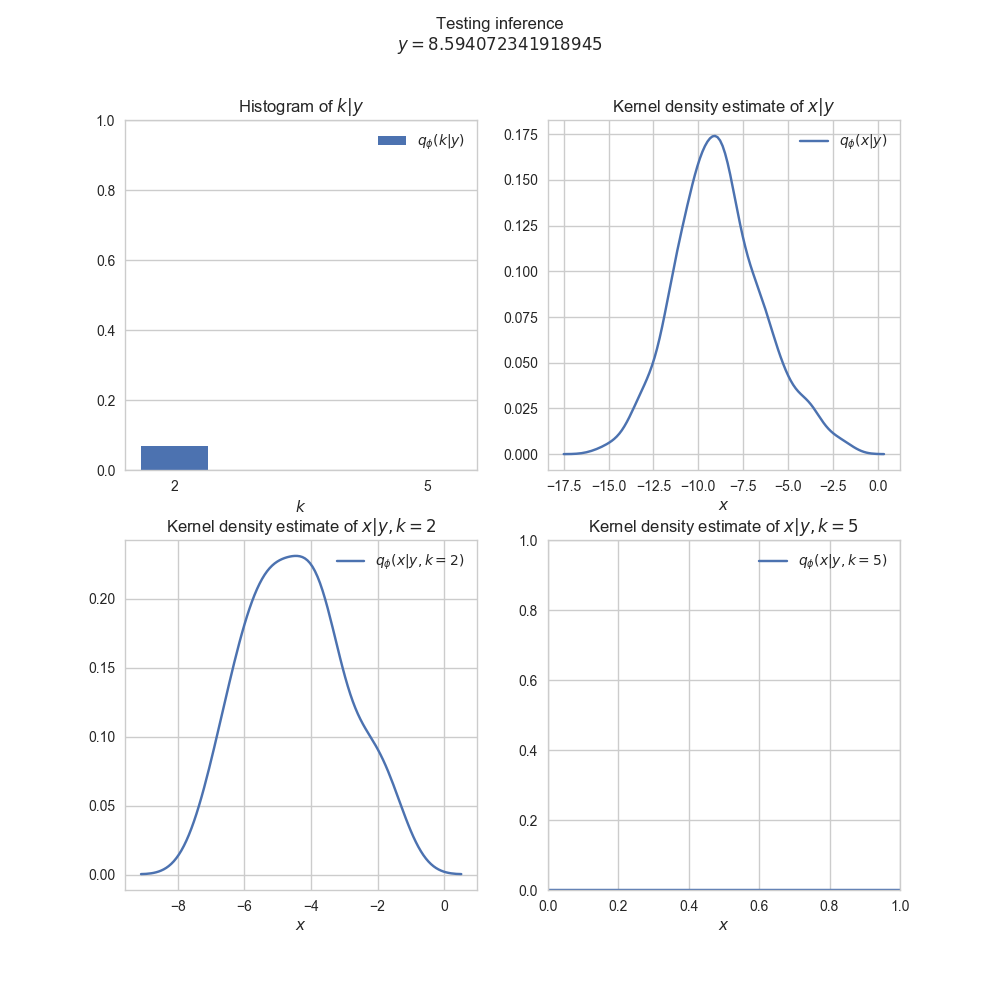

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Testing inference\n$y = {}$'.format(y_test))
bar_width = 0.8

##############
##############
##############

num_inference_network_samples = 1000
y = torch.Tensor([[y_test]]).expand(num_inference_network_samples, 1)
k, x = inference_network.sample(y)

values = [2, 5]
normalized_weights = [
    torch.sum(k == 2) / len(k),
    torch.sum(k == 5) / len(k),
]
bar1 = ax[0][0].bar(np.array(values), normalized_weights, width=bar_width, tick_label=values, color=colors[0], label='$q_{\phi}(k | y)$')
sns.kdeplot(x.view(-1).numpy(), ax=ax[0][1], label='$q_{\phi}(x | y)$', color=colors[0])

if len(x[k == 2]) != 0:
    sns.kdeplot(x[k == 2].view(-1).numpy(), ax=ax[1][0], label='$q_{\phi}(x | y, k = 2)$', color=colors[0])
else:
    ax[1][0].axhline(0, label='$q_{\phi}(x | y, k = 2)$', color=colors[0])

if len(x[k == 5]) != 0:
    sns.kdeplot(x[k == 5].view(-1).numpy(), ax=ax[1][1], label='$q_{\phi}(x | y, k = 5)$', color=colors[0])
else:
    ax[1][1].axhline(0, label='$q_{\phi}(x | y, k = 5)$', color=colors[0])

##############
##############
##############

ax[0][0].xaxis.grid(False)
ax[0][0].set_ylim([0, 1])
ax[0][0].set_title('Histogram of $k | y$')
ax[0][0].set_xlabel('$k$')
ax[0][0].legend()

ax[0][1].set_title('Kernel density estimate of $x | y$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $x | y, k = 2$')
ax[1][0].set_xlabel('$x$')

ax[1][1].set_title('Kernel density estimate of $x | y, k = 5$')
ax[1][1].set_xlabel('$x$')
ax[1][1].legend()

# Training Loop

In [6]:
inference_network = quadratic.InferenceNetwork()
generative_network = quadratic.GenerativeNetwork()

inference_network_optim = optim.Adam(inference_network.parameters())
generative_network_optim = optim.Adam(generative_network.parameters())

num_iterations = 30
batch_size = 1000
num_data = 1000
generative_epochs_per_iteration = 60
inference_epochs_per_iteration = 40
num_generative_epochs = np.repeat(generative_epochs_per_iteration, num_iterations)
num_inference_epochs = np.repeat(inference_epochs_per_iteration, num_iterations)

data_generator = lambda: generative_model.sample(1)[2][0][0]
quadratic_dataset = quadratic.Dataset(infinite_data=False, num_data=num_data, data_generator=data_generator)
quadratic_dataloader = torch.utils.data.DataLoader(quadratic_dataset, batch_size=batch_size, shuffle=True)

generative_network_objective = []
inference_network_objective = []
if opt.visdom:
    util.vis.close()
    generative_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to maximize)',
            title='Generative network objective'
        )
    )
    
    inference_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to minimize)',
            title='Inference network objective'
        )
    )

for i in range(num_iterations):
    util.logger.info('Iteration {}'.format(i))
    
    # Step 1
    for epoch in range(num_generative_epochs[i]):
        temp_generative_network_objective = []
        for _, y in enumerate(quadratic_dataloader):
            k, x = inference_network.sample(y.unsqueeze(1))
            
            generative_network_optim.zero_grad()
            logpdf_generative_network = generative_network.forward(Variable(k), Variable(x), Variable(y))
            temp_generative_network_objective += logpdf_generative_network.data.numpy().tolist()
            utility = torch.mean(logpdf_generative_network)
            loss = -utility # we want to maximize
            loss.backward()
            generative_network_optim.step()
        generative_network_objective.append(np.mean(temp_generative_network_objective))
        
        util.vis.line(
            X=np.arange(len(generative_network_objective)),
            Y=np.nan_to_num(np.array(generative_network_objective)),
            update='replace',
            win=generative_network_objective_line
        )
        util.logger.info('Generative network step | Epoch {0} | Objective {1}'.format(epoch, generative_network_objective[-1]))
    
    # Step 2
    for epoch in range(num_inference_epochs[i]):
        temp_inference_network_objective = []
        for batch_size in util.chunk(num_data, batch_size):
            k, x, y = generative_network.sample(batch_size)
            
            inference_network_optim.zero_grad()
            logpdf_inference_network = inference_network.forward(Variable(k), Variable(x), Variable(y))
            temp_inference_network_objective += (-logpdf_inference_network).data.numpy().tolist()
            loss = torch.mean(-logpdf_inference_network)
            loss.backward()
            inference_network_optim.step()
        inference_network_objective.append(np.mean(temp_inference_network_objective))
        util.vis.line(
            X=np.arange(len(inference_network_objective)),
            Y=np.nan_to_num(np.array(inference_network_objective)),
            update='replace',
            win=inference_network_objective_line
        )
        util.logger.info('Inference network step | Epoch {0} | Objective {1}'.format(epoch, inference_network_objective[-1]))

2017-07-25 18:13:52,882: Iteration 0
2017-07-25 18:13:52,931: Generative network step | Epoch 0 | Objective -6211.85956753397
2017-07-25 18:13:52,990: Generative network step | Epoch 1 | Objective -6182.211708053827
2017-07-25 18:13:53,058: Generative network step | Epoch 2 | Objective -6152.819581557751
2017-07-25 18:13:53,123: Generative network step | Epoch 3 | Objective -6123.941808692455
2017-07-25 18:13:53,193: Generative network step | Epoch 4 | Objective -6094.3454804797175
2017-07-25 18:13:53,257: Generative network step | Epoch 5 | Objective -6065.1158543334
2017-07-25 18:13:53,325: Generative network step | Epoch 6 | Objective -6036.068979409694
2017-07-25 18:13:53,388: Generative network step | Epoch 7 | Objective -6007.25537366724
2017-07-25 18:13:53,516: Generative network step | Epoch 8 | Objective -5978.2386037712095
2017-07-25 18:13:53,578: Generative network step | Epoch 9 | Objective -5949.946118347645
2017-07-25 18:13:53,643: Generative network step | Epoch 10 | Obj

2017-07-25 18:13:58,765: Inference network step | Epoch 31 | Objective 1226.2716799834966
2017-07-25 18:13:58,825: Inference network step | Epoch 32 | Objective 1155.8416869448424
2017-07-25 18:13:58,889: Inference network step | Epoch 33 | Objective 1125.1121957342625
2017-07-25 18:13:58,950: Inference network step | Epoch 34 | Objective 1074.4284518398047
2017-07-25 18:13:59,016: Inference network step | Epoch 35 | Objective 1073.8615037298202
2017-07-25 18:13:59,078: Inference network step | Epoch 36 | Objective 962.1412160485983
2017-07-25 18:13:59,142: Inference network step | Epoch 37 | Objective 921.9710535453557
2017-07-25 18:13:59,200: Inference network step | Epoch 38 | Objective 934.0981733551025
2017-07-25 18:13:59,256: Inference network step | Epoch 39 | Objective 910.0289759281874
2017-07-25 18:13:59,257: Iteration 1
2017-07-25 18:13:59,321: Generative network step | Epoch 0 | Objective -4273.893879399061
2017-07-25 18:13:59,386: Generative network step | Epoch 1 | Object

2017-07-25 18:14:04,462: Inference network step | Epoch 22 | Objective 439.3901302646399
2017-07-25 18:14:04,524: Inference network step | Epoch 23 | Objective 444.6315105673075
2017-07-25 18:14:04,586: Inference network step | Epoch 24 | Objective 428.87534941768644
2017-07-25 18:14:04,643: Inference network step | Epoch 25 | Objective 405.3597310433388
2017-07-25 18:14:04,704: Inference network step | Epoch 26 | Objective 400.82505953371526
2017-07-25 18:14:04,767: Inference network step | Epoch 27 | Objective 402.30046875059605
2017-07-25 18:14:04,819: Inference network step | Epoch 28 | Objective 361.7057158074379
2017-07-25 18:14:04,883: Inference network step | Epoch 29 | Objective 401.9804079210758
2017-07-25 18:14:04,944: Inference network step | Epoch 30 | Objective 376.6776153726578
2017-07-25 18:14:05,006: Inference network step | Epoch 31 | Objective 391.0001906465292
2017-07-25 18:14:05,069: Inference network step | Epoch 32 | Objective 345.6112113165855
2017-07-25 18:14:0

2017-07-25 18:14:10,265: Inference network step | Epoch 13 | Objective 125.62146492516995
2017-07-25 18:14:10,331: Inference network step | Epoch 14 | Objective 121.26403224086762
2017-07-25 18:14:10,396: Inference network step | Epoch 15 | Objective 119.91490268146991
2017-07-25 18:14:10,459: Inference network step | Epoch 16 | Objective 118.22451598310471
2017-07-25 18:14:10,527: Inference network step | Epoch 17 | Objective 106.83403616937996
2017-07-25 18:14:10,593: Inference network step | Epoch 18 | Objective 107.24131849563122
2017-07-25 18:14:10,651: Inference network step | Epoch 19 | Objective 100.04376261770726
2017-07-25 18:14:10,710: Inference network step | Epoch 20 | Objective 107.73368243226409
2017-07-25 18:14:10,766: Inference network step | Epoch 21 | Objective 103.83098551666737
2017-07-25 18:14:10,823: Inference network step | Epoch 22 | Objective 88.64008799725771
2017-07-25 18:14:10,879: Inference network step | Epoch 23 | Objective 87.50399669313431
2017-07-25 1

2017-07-25 18:14:16,120: Inference network step | Epoch 3 | Objective 25.36921478831768
2017-07-25 18:14:16,186: Inference network step | Epoch 4 | Objective 22.17602563601732
2017-07-25 18:14:16,249: Inference network step | Epoch 5 | Objective 24.136917612701655
2017-07-25 18:14:16,315: Inference network step | Epoch 6 | Objective 22.50058244934678
2017-07-25 18:14:16,372: Inference network step | Epoch 7 | Objective 22.40411323609948
2017-07-25 18:14:16,440: Inference network step | Epoch 8 | Objective 19.756624399989843
2017-07-25 18:14:16,498: Inference network step | Epoch 9 | Objective 17.954002785742283
2017-07-25 18:14:16,555: Inference network step | Epoch 10 | Objective 16.420353372633457
2017-07-25 18:14:16,618: Inference network step | Epoch 11 | Objective 16.891060794621705
2017-07-25 18:14:16,673: Inference network step | Epoch 12 | Objective 16.15287247696519
2017-07-25 18:14:16,736: Inference network step | Epoch 13 | Objective 14.61558455234766
2017-07-25 18:14:16,800

2017-07-25 18:14:22,218: Generative network step | Epoch 53 | Objective -1652.2782976412773
2017-07-25 18:14:22,290: Generative network step | Epoch 54 | Objective -1645.7722792577742
2017-07-25 18:14:22,359: Generative network step | Epoch 55 | Objective -1639.477534811735
2017-07-25 18:14:22,429: Generative network step | Epoch 56 | Objective -1633.9038973507882
2017-07-25 18:14:22,500: Generative network step | Epoch 57 | Objective -1625.1301866517067
2017-07-25 18:14:22,573: Generative network step | Epoch 58 | Objective -1619.5661532182694
2017-07-25 18:14:22,646: Generative network step | Epoch 59 | Objective -1615.208810480833
2017-07-25 18:14:22,719: Inference network step | Epoch 0 | Objective 5.863664762094617
2017-07-25 18:14:22,788: Inference network step | Epoch 1 | Objective 5.438216378927231
2017-07-25 18:14:22,854: Inference network step | Epoch 2 | Objective 5.127889582097531
2017-07-25 18:14:22,918: Inference network step | Epoch 3 | Objective 5.735552142053843
2017-0

2017-07-25 18:14:28,495: Generative network step | Epoch 44 | Objective -1278.782899204731
2017-07-25 18:14:28,562: Generative network step | Epoch 45 | Objective -1273.779322371006
2017-07-25 18:14:28,631: Generative network step | Epoch 46 | Objective -1270.4666142618655
2017-07-25 18:14:28,696: Generative network step | Epoch 47 | Objective -1260.19539473629
2017-07-25 18:14:28,768: Generative network step | Epoch 48 | Objective -1255.6364454607963
2017-07-25 18:14:28,835: Generative network step | Epoch 49 | Objective -1251.8893870429993
2017-07-25 18:14:28,904: Generative network step | Epoch 50 | Objective -1242.7224900119304
2017-07-25 18:14:28,966: Generative network step | Epoch 51 | Objective -1239.1837243256568
2017-07-25 18:14:29,038: Generative network step | Epoch 52 | Objective -1227.5261267032624
2017-07-25 18:14:29,103: Generative network step | Epoch 53 | Objective -1227.616552913189
2017-07-25 18:14:29,174: Generative network step | Epoch 54 | Objective -1218.7427243

2017-07-25 18:14:34,898: Generative network step | Epoch 35 | Objective -944.4374551985264
2017-07-25 18:14:34,972: Generative network step | Epoch 36 | Objective -936.4092391004563
2017-07-25 18:14:35,047: Generative network step | Epoch 37 | Objective -933.629542245388
2017-07-25 18:14:35,122: Generative network step | Epoch 38 | Objective -926.8436240508556
2017-07-25 18:14:35,189: Generative network step | Epoch 39 | Objective -920.0639973187447
2017-07-25 18:14:35,266: Generative network step | Epoch 40 | Objective -922.9743560147285
2017-07-25 18:14:35,339: Generative network step | Epoch 41 | Objective -914.8331185383797
2017-07-25 18:14:35,411: Generative network step | Epoch 42 | Objective -903.9240284171104
2017-07-25 18:14:35,482: Generative network step | Epoch 43 | Objective -901.5860298979283
2017-07-25 18:14:35,560: Generative network step | Epoch 44 | Objective -898.8587242906094
2017-07-25 18:14:35,633: Generative network step | Epoch 45 | Objective -890.0714962894916


2017-07-25 18:14:41,304: Generative network step | Epoch 26 | Objective -615.5132764229775
2017-07-25 18:14:41,377: Generative network step | Epoch 27 | Objective -621.4370697028637
2017-07-25 18:14:41,451: Generative network step | Epoch 28 | Objective -607.803848019123
2017-07-25 18:14:41,518: Generative network step | Epoch 29 | Objective -603.8013918318749
2017-07-25 18:14:41,586: Generative network step | Epoch 30 | Objective -604.0480850698948
2017-07-25 18:14:41,654: Generative network step | Epoch 31 | Objective -599.6121911728383
2017-07-25 18:14:41,729: Generative network step | Epoch 32 | Objective -586.2644445266724
2017-07-25 18:14:41,799: Generative network step | Epoch 33 | Objective -591.3903087394237
2017-07-25 18:14:41,873: Generative network step | Epoch 34 | Objective -584.0450302500725
2017-07-25 18:14:41,940: Generative network step | Epoch 35 | Objective -575.91603962183
2017-07-25 18:14:42,014: Generative network step | Epoch 36 | Objective -573.1308960571289
20

2017-07-25 18:14:47,814: Generative network step | Epoch 17 | Objective -451.0414133760929
2017-07-25 18:14:47,892: Generative network step | Epoch 18 | Objective -429.73346896362307
2017-07-25 18:14:47,966: Generative network step | Epoch 19 | Objective -432.1974889931679
2017-07-25 18:14:48,048: Generative network step | Epoch 20 | Objective -432.66712176561356
2017-07-25 18:14:48,123: Generative network step | Epoch 21 | Objective -429.5500440170765
2017-07-25 18:14:48,198: Generative network step | Epoch 22 | Objective -428.4416159982681
2017-07-25 18:14:48,271: Generative network step | Epoch 23 | Objective -430.83256108117104
2017-07-25 18:14:48,346: Generative network step | Epoch 24 | Objective -420.73238563132287
2017-07-25 18:14:48,413: Generative network step | Epoch 25 | Objective -417.66820303726195
2017-07-25 18:14:48,488: Generative network step | Epoch 26 | Objective -416.80114522504806
2017-07-25 18:14:48,561: Generative network step | Epoch 27 | Objective -419.2747045

2017-07-25 18:14:54,522: Generative network step | Epoch 8 | Objective -311.33119619727137
2017-07-25 18:14:54,601: Generative network step | Epoch 9 | Objective -316.56315864348414
2017-07-25 18:14:54,675: Generative network step | Epoch 10 | Objective -306.5157356338501
2017-07-25 18:14:54,757: Generative network step | Epoch 11 | Objective -313.5105898749828
2017-07-25 18:14:54,832: Generative network step | Epoch 12 | Objective -310.2242166097164
2017-07-25 18:14:54,908: Generative network step | Epoch 13 | Objective -306.5739474477768
2017-07-25 18:14:54,983: Generative network step | Epoch 14 | Objective -310.10964773988724
2017-07-25 18:14:55,056: Generative network step | Epoch 15 | Objective -307.47389181518554
2017-07-25 18:14:55,129: Generative network step | Epoch 16 | Objective -307.23167719316484
2017-07-25 18:14:55,204: Generative network step | Epoch 17 | Objective -307.78978056287764
2017-07-25 18:14:55,278: Generative network step | Epoch 18 | Objective -298.742503001

2017-07-25 18:15:01,245: Inference network step | Epoch 39 | Objective 1.5653054300695657
2017-07-25 18:15:01,246: Iteration 10
2017-07-25 18:15:01,327: Generative network step | Epoch 0 | Objective -264.0999379878044
2017-07-25 18:15:01,413: Generative network step | Epoch 1 | Objective -261.8684602518082
2017-07-25 18:15:01,495: Generative network step | Epoch 2 | Objective -262.5034078719616
2017-07-25 18:15:01,577: Generative network step | Epoch 3 | Objective -263.28354519605637
2017-07-25 18:15:01,655: Generative network step | Epoch 4 | Objective -263.65649677777293
2017-07-25 18:15:01,734: Generative network step | Epoch 5 | Objective -254.39715047955514
2017-07-25 18:15:01,812: Generative network step | Epoch 6 | Objective -255.39968705630304
2017-07-25 18:15:01,893: Generative network step | Epoch 7 | Objective -260.0462335758209
2017-07-25 18:15:01,973: Generative network step | Epoch 8 | Objective -258.1195044622421
2017-07-25 18:15:02,054: Generative network step | Epoch 9

2017-07-25 18:15:08,351: Inference network step | Epoch 29 | Objective 3.9153614297751336
2017-07-25 18:15:08,428: Inference network step | Epoch 30 | Objective 3.393686712326482
2017-07-25 18:15:08,511: Inference network step | Epoch 31 | Objective 2.982131840219721
2017-07-25 18:15:08,589: Inference network step | Epoch 32 | Objective 3.6366178171150385
2017-07-25 18:15:08,666: Inference network step | Epoch 33 | Objective 3.193460611261427
2017-07-25 18:15:08,737: Inference network step | Epoch 34 | Objective 3.660303008629009
2017-07-25 18:15:08,817: Inference network step | Epoch 35 | Objective 3.2561720910295846
2017-07-25 18:15:08,894: Inference network step | Epoch 36 | Objective 3.40225124328956
2017-07-25 18:15:08,978: Inference network step | Epoch 37 | Objective 3.772345260118134
2017-07-25 18:15:09,054: Inference network step | Epoch 38 | Objective 2.8418370562735946
2017-07-25 18:15:09,140: Inference network step | Epoch 39 | Objective 2.956773173689842
2017-07-25 18:15:0

2017-07-25 18:15:15,833: Inference network step | Epoch 20 | Objective 12.692166618473827
2017-07-25 18:15:15,919: Inference network step | Epoch 21 | Objective 11.703956940401346
2017-07-25 18:15:15,998: Inference network step | Epoch 22 | Objective 13.317129417419434
2017-07-25 18:15:16,091: Inference network step | Epoch 23 | Objective 11.069482455704362
2017-07-25 18:15:16,172: Inference network step | Epoch 24 | Objective 11.153294042795897
2017-07-25 18:15:16,257: Inference network step | Epoch 25 | Objective 12.630144082367421
2017-07-25 18:15:16,338: Inference network step | Epoch 26 | Objective 11.397151630107313
2017-07-25 18:15:16,423: Inference network step | Epoch 27 | Objective 10.836980162151157
2017-07-25 18:15:16,500: Inference network step | Epoch 28 | Objective 9.443696354854852
2017-07-25 18:15:16,579: Inference network step | Epoch 29 | Objective 12.424446750830858
2017-07-25 18:15:16,661: Inference network step | Epoch 30 | Objective 10.729258836526423
2017-07-25 

2017-07-25 18:15:23,824: Inference network step | Epoch 11 | Objective 31.079460614964365
2017-07-25 18:15:23,909: Inference network step | Epoch 12 | Objective 29.946825405180455
2017-07-25 18:15:23,993: Inference network step | Epoch 13 | Objective 28.75828901319206
2017-07-25 18:15:24,089: Inference network step | Epoch 14 | Objective 32.158371313124896
2017-07-25 18:15:24,175: Inference network step | Epoch 15 | Objective 32.42175584040582
2017-07-25 18:15:24,263: Inference network step | Epoch 16 | Objective 26.751354090347885
2017-07-25 18:15:24,336: Inference network step | Epoch 17 | Objective 24.46299689513445
2017-07-25 18:15:24,422: Inference network step | Epoch 18 | Objective 25.454977153994143
2017-07-25 18:15:24,504: Inference network step | Epoch 19 | Objective 25.403245906911792
2017-07-25 18:15:24,593: Inference network step | Epoch 20 | Objective 22.134334810100494
2017-07-25 18:15:24,679: Inference network step | Epoch 21 | Objective 23.053848550915717
2017-07-25 18

2017-07-25 18:15:31,949: Inference network step | Epoch 1 | Objective 15.85819874817133
2017-07-25 18:15:32,054: Inference network step | Epoch 2 | Objective 15.266360280744731
2017-07-25 18:15:32,139: Inference network step | Epoch 3 | Objective 16.241491753235458
2017-07-25 18:15:32,232: Inference network step | Epoch 4 | Objective 15.819467850364745
2017-07-25 18:15:32,321: Inference network step | Epoch 5 | Objective 13.82111435290426
2017-07-25 18:15:32,414: Inference network step | Epoch 6 | Objective 12.938328902624548
2017-07-25 18:15:32,504: Inference network step | Epoch 7 | Objective 13.33375533607602
2017-07-25 18:15:32,595: Inference network step | Epoch 8 | Objective 13.36168638858199
2017-07-25 18:15:32,683: Inference network step | Epoch 9 | Objective 13.028904418930411
2017-07-25 18:15:32,768: Inference network step | Epoch 10 | Objective 10.66407122310996
2017-07-25 18:15:32,852: Inference network step | Epoch 11 | Objective 12.228152453422547
2017-07-25 18:15:32,937:

2017-07-25 18:15:40,917: Generative network step | Epoch 52 | Objective -518.298812344551
2017-07-25 18:15:41,021: Generative network step | Epoch 53 | Objective -518.6530639595985
2017-07-25 18:15:41,122: Generative network step | Epoch 54 | Objective -518.5981180458069
2017-07-25 18:15:41,225: Generative network step | Epoch 55 | Objective -518.6924660253525
2017-07-25 18:15:41,332: Generative network step | Epoch 56 | Objective -517.9458137896061
2017-07-25 18:15:41,442: Generative network step | Epoch 57 | Objective -518.6344067134858
2017-07-25 18:15:41,548: Generative network step | Epoch 58 | Objective -517.875566908598
2017-07-25 18:15:41,659: Generative network step | Epoch 59 | Objective -518.6502714807987
2017-07-25 18:15:41,767: Inference network step | Epoch 0 | Objective 7.893074923336506
2017-07-25 18:15:41,869: Inference network step | Epoch 1 | Objective 7.801169716179371
2017-07-25 18:15:41,973: Inference network step | Epoch 2 | Objective 8.135793936252593
2017-07-25

2017-07-25 18:15:50,784: Generative network step | Epoch 43 | Objective -512.9107581803798
2017-07-25 18:15:50,901: Generative network step | Epoch 44 | Objective -512.6826171815395
2017-07-25 18:15:51,013: Generative network step | Epoch 45 | Objective -512.0212541534901
2017-07-25 18:15:51,142: Generative network step | Epoch 46 | Objective -511.56412717485426
2017-07-25 18:15:51,282: Generative network step | Epoch 47 | Objective -512.7022299828529
2017-07-25 18:15:51,425: Generative network step | Epoch 48 | Objective -512.9741826329231
2017-07-25 18:15:51,566: Generative network step | Epoch 49 | Objective -511.81376294231416
2017-07-25 18:15:51,701: Generative network step | Epoch 50 | Objective -512.6445068271161
2017-07-25 18:15:51,830: Generative network step | Epoch 51 | Objective -512.759749966383
2017-07-25 18:15:51,955: Generative network step | Epoch 52 | Objective -512.3475187065601
2017-07-25 18:15:52,095: Generative network step | Epoch 53 | Objective -511.407561786413

2017-07-25 18:16:02,560: Generative network step | Epoch 34 | Objective -505.7908932926655
2017-07-25 18:16:02,705: Generative network step | Epoch 35 | Objective -505.8973051240444
2017-07-25 18:16:02,860: Generative network step | Epoch 36 | Objective -505.473027700901
2017-07-25 18:16:03,001: Generative network step | Epoch 37 | Objective -505.89723633813855
2017-07-25 18:16:03,147: Generative network step | Epoch 38 | Objective -506.5488666405678
2017-07-25 18:16:03,294: Generative network step | Epoch 39 | Objective -506.6207573003769
2017-07-25 18:16:03,442: Generative network step | Epoch 40 | Objective -505.7230559000969
2017-07-25 18:16:03,587: Generative network step | Epoch 41 | Objective -505.33491046905516
2017-07-25 18:16:03,732: Generative network step | Epoch 42 | Objective -506.46071541333197
2017-07-25 18:16:03,866: Generative network step | Epoch 43 | Objective -507.10958575749396
2017-07-25 18:16:04,010: Generative network step | Epoch 44 | Objective -506.7745361850

2017-07-25 18:16:16,354: Generative network step | Epoch 25 | Objective -499.3234919192791
2017-07-25 18:16:16,514: Generative network step | Epoch 26 | Objective -499.43008452415467
2017-07-25 18:16:16,674: Generative network step | Epoch 27 | Objective -498.0156892511845
2017-07-25 18:16:16,838: Generative network step | Epoch 28 | Objective -499.2692686021328
2017-07-25 18:16:17,000: Generative network step | Epoch 29 | Objective -499.2143119752407
2017-07-25 18:16:17,152: Generative network step | Epoch 30 | Objective -499.294533452034
2017-07-25 18:16:17,308: Generative network step | Epoch 31 | Objective -498.84329060053824
2017-07-25 18:16:17,473: Generative network step | Epoch 32 | Objective -498.9668206703663
2017-07-25 18:16:17,628: Generative network step | Epoch 33 | Objective -499.2540416097641
2017-07-25 18:16:17,794: Generative network step | Epoch 34 | Objective -501.05235213637354
2017-07-25 18:16:17,963: Generative network step | Epoch 35 | Objective -498.84879403471

2017-07-25 18:16:32,406: Generative network step | Epoch 16 | Objective -490.05736754131317
2017-07-25 18:16:32,602: Generative network step | Epoch 17 | Objective -490.0157952861786
2017-07-25 18:16:32,797: Generative network step | Epoch 18 | Objective -490.17721514868737
2017-07-25 18:16:32,988: Generative network step | Epoch 19 | Objective -490.1449943242073
2017-07-25 18:16:33,172: Generative network step | Epoch 20 | Objective -490.0991207892895
2017-07-25 18:16:33,361: Generative network step | Epoch 21 | Objective -490.00472028779984
2017-07-25 18:16:33,558: Generative network step | Epoch 22 | Objective -489.69002419161797
2017-07-25 18:16:33,750: Generative network step | Epoch 23 | Objective -490.0267371079922
2017-07-25 18:16:33,942: Generative network step | Epoch 24 | Objective -490.05606360793115
2017-07-25 18:16:34,154: Generative network step | Epoch 25 | Objective -489.99384455418584
2017-07-25 18:16:34,347: Generative network step | Epoch 26 | Objective -490.2144829

2017-07-25 18:16:49,884: Generative network step | Epoch 7 | Objective -492.91529918694494
2017-07-25 18:16:50,095: Generative network step | Epoch 8 | Objective -492.59497586894037
2017-07-25 18:16:50,301: Generative network step | Epoch 9 | Objective -493.00874492526054
2017-07-25 18:16:50,506: Generative network step | Epoch 10 | Objective -492.68603437924384
2017-07-25 18:16:50,735: Generative network step | Epoch 11 | Objective -492.67684656858444
2017-07-25 18:16:50,952: Generative network step | Epoch 12 | Objective -492.9095187892914
2017-07-25 18:16:51,164: Generative network step | Epoch 13 | Objective -492.59954926395415
2017-07-25 18:16:51,376: Generative network step | Epoch 14 | Objective -492.84992065024375
2017-07-25 18:16:51,587: Generative network step | Epoch 15 | Objective -492.5740634150505
2017-07-25 18:16:51,806: Generative network step | Epoch 16 | Objective -492.60248310160637
2017-07-25 18:16:52,017: Generative network step | Epoch 17 | Objective -492.77081686

2017-07-25 18:17:07,849: Inference network step | Epoch 38 | Objective 1.6678343538045883
2017-07-25 18:17:08,045: Inference network step | Epoch 39 | Objective 1.643656830906868
2017-07-25 18:17:08,048: Iteration 20
2017-07-25 18:17:08,259: Generative network step | Epoch 0 | Objective -492.4230013010502
2017-07-25 18:17:08,455: Generative network step | Epoch 1 | Objective -492.2420662589073
2017-07-25 18:17:08,653: Generative network step | Epoch 2 | Objective -492.4662014336586
2017-07-25 18:17:08,848: Generative network step | Epoch 3 | Objective -492.2604061901569
2017-07-25 18:17:09,048: Generative network step | Epoch 4 | Objective -492.47742809176447
2017-07-25 18:17:09,241: Generative network step | Epoch 5 | Objective -492.4166926403046
2017-07-25 18:17:09,432: Generative network step | Epoch 6 | Objective -492.46975035738944
2017-07-25 18:17:09,635: Generative network step | Epoch 7 | Objective -492.2710994286537
2017-07-25 18:17:09,839: Generative network step | Epoch 8 | 

2017-07-25 18:17:24,421: Inference network step | Epoch 28 | Objective 1.621038547039032
2017-07-25 18:17:24,571: Inference network step | Epoch 29 | Objective 1.6073770077228546
2017-07-25 18:17:24,726: Inference network step | Epoch 30 | Objective 1.6177176424264907
2017-07-25 18:17:24,891: Inference network step | Epoch 31 | Objective 1.5996941069364548
2017-07-25 18:17:25,068: Inference network step | Epoch 32 | Objective 1.6012448408603668
2017-07-25 18:17:25,244: Inference network step | Epoch 33 | Objective 1.5809030306339265
2017-07-25 18:17:25,423: Inference network step | Epoch 34 | Objective 1.6002385667562484
2017-07-25 18:17:25,609: Inference network step | Epoch 35 | Objective 1.591007256269455
2017-07-25 18:17:25,783: Inference network step | Epoch 36 | Objective 1.5800744243860245
2017-07-25 18:17:25,960: Inference network step | Epoch 37 | Objective 1.5766908130645751
2017-07-25 18:17:26,137: Inference network step | Epoch 38 | Objective 1.6044722595214844
2017-07-25 1

2017-07-25 18:17:40,137: Inference network step | Epoch 19 | Objective 1.5442708195447923
2017-07-25 18:17:40,296: Inference network step | Epoch 20 | Objective 1.5587373972535132
2017-07-25 18:17:40,459: Inference network step | Epoch 21 | Objective 1.5580043585896493
2017-07-25 18:17:40,635: Inference network step | Epoch 22 | Objective 1.562845775961876
2017-07-25 18:17:40,797: Inference network step | Epoch 23 | Objective 1.5377353219389915
2017-07-25 18:17:40,959: Inference network step | Epoch 24 | Objective 1.5799058686494827
2017-07-25 18:17:41,110: Inference network step | Epoch 25 | Objective 1.5457896863818168
2017-07-25 18:17:41,265: Inference network step | Epoch 26 | Objective 1.561331722676754
2017-07-25 18:17:41,433: Inference network step | Epoch 27 | Objective 1.5757974389195442
2017-07-25 18:17:41,590: Inference network step | Epoch 28 | Objective 1.5415128321647644
2017-07-25 18:17:41,749: Inference network step | Epoch 29 | Objective 1.543795874774456
2017-07-25 18

2017-07-25 18:17:55,742: Inference network step | Epoch 9 | Objective 1.526726427078247
2017-07-25 18:17:55,899: Inference network step | Epoch 10 | Objective 1.5204428176879883
2017-07-25 18:17:56,064: Inference network step | Epoch 11 | Objective 1.532233537554741
2017-07-25 18:17:56,221: Inference network step | Epoch 12 | Objective 1.5225145474672317
2017-07-25 18:17:56,377: Inference network step | Epoch 13 | Objective 1.5466086923480034
2017-07-25 18:17:56,535: Inference network step | Epoch 14 | Objective 1.5344306227564812
2017-07-25 18:17:56,696: Inference network step | Epoch 15 | Objective 1.507985483944416
2017-07-25 18:17:56,855: Inference network step | Epoch 16 | Objective 1.5177132771611215
2017-07-25 18:17:57,013: Inference network step | Epoch 17 | Objective 1.5084115828275682
2017-07-25 18:17:57,166: Inference network step | Epoch 18 | Objective 1.5231284831762313
2017-07-25 18:17:57,323: Inference network step | Epoch 19 | Objective 1.4991525872945786
2017-07-25 18:

2017-07-25 18:18:10,840: Generative network step | Epoch 59 | Objective -462.7609115526676
2017-07-25 18:18:11,007: Inference network step | Epoch 0 | Objective 1.4873543322086333
2017-07-25 18:18:11,172: Inference network step | Epoch 1 | Objective 1.4884568472504616
2017-07-25 18:18:11,339: Inference network step | Epoch 2 | Objective 1.5049892416596413
2017-07-25 18:18:11,508: Inference network step | Epoch 3 | Objective 1.4687276092171668
2017-07-25 18:18:11,671: Inference network step | Epoch 4 | Objective 1.4618040716052056
2017-07-25 18:18:11,832: Inference network step | Epoch 5 | Objective 1.4970998209118842
2017-07-25 18:18:11,999: Inference network step | Epoch 6 | Objective 1.4919534841775894
2017-07-25 18:18:12,172: Inference network step | Epoch 7 | Objective 1.4797303839325904
2017-07-25 18:18:12,340: Inference network step | Epoch 8 | Objective 1.476365787625313
2017-07-25 18:18:12,500: Inference network step | Epoch 9 | Objective 1.4842660849690437
2017-07-25 18:18:12,

2017-07-25 18:18:25,774: Generative network step | Epoch 50 | Objective -448.0077746043205
2017-07-25 18:18:25,930: Generative network step | Epoch 51 | Objective -448.08112145280836
2017-07-25 18:18:26,095: Generative network step | Epoch 52 | Objective -447.8353889830112
2017-07-25 18:18:26,252: Generative network step | Epoch 53 | Objective -447.8318550901413
2017-07-25 18:18:26,409: Generative network step | Epoch 54 | Objective -448.02750018906596
2017-07-25 18:18:26,566: Generative network step | Epoch 55 | Objective -447.88593056321145
2017-07-25 18:18:26,720: Generative network step | Epoch 56 | Objective -447.8452009732723
2017-07-25 18:18:26,916: Generative network step | Epoch 57 | Objective -448.1937334980965
2017-07-25 18:18:27,082: Generative network step | Epoch 58 | Objective -448.10122011828423
2017-07-25 18:18:27,246: Generative network step | Epoch 59 | Objective -447.96897302412987
2017-07-25 18:18:27,405: Inference network step | Epoch 0 | Objective 1.4525644188523

2017-07-25 18:18:39,553: Generative network step | Epoch 41 | Objective -430.45565297961235
2017-07-25 18:18:39,714: Generative network step | Epoch 42 | Objective -430.4235955469608
2017-07-25 18:18:39,876: Generative network step | Epoch 43 | Objective -430.3466248137951
2017-07-25 18:18:40,041: Generative network step | Epoch 44 | Objective -430.30809342217447
2017-07-25 18:18:40,293: Generative network step | Epoch 45 | Objective -430.38248847222326
2017-07-25 18:18:40,436: Generative network step | Epoch 46 | Objective -430.4297859926224
2017-07-25 18:18:40,583: Generative network step | Epoch 47 | Objective -430.61084334635734
2017-07-25 18:18:40,750: Generative network step | Epoch 48 | Objective -430.47309490537646
2017-07-25 18:18:40,913: Generative network step | Epoch 49 | Objective -430.50160702610015
2017-07-25 18:18:41,078: Generative network step | Epoch 50 | Objective -430.2944869983196
2017-07-25 18:18:41,237: Generative network step | Epoch 51 | Objective -430.3670403

2017-07-25 18:18:52,811: Generative network step | Epoch 32 | Objective -411.00303189587595
2017-07-25 18:18:52,946: Generative network step | Epoch 33 | Objective -411.10691194915773
2017-07-25 18:18:53,082: Generative network step | Epoch 34 | Objective -410.7415552341938
2017-07-25 18:18:53,213: Generative network step | Epoch 35 | Objective -410.9905995721817
2017-07-25 18:18:53,342: Generative network step | Epoch 36 | Objective -411.02942765331267
2017-07-25 18:18:53,482: Generative network step | Epoch 37 | Objective -411.10240914011
2017-07-25 18:18:53,616: Generative network step | Epoch 38 | Objective -410.9738221576214
2017-07-25 18:18:53,745: Generative network step | Epoch 39 | Objective -410.96762287712096
2017-07-25 18:18:53,889: Generative network step | Epoch 40 | Objective -410.9507725098133
2017-07-25 18:18:54,038: Generative network step | Epoch 41 | Objective -411.02023026657105
2017-07-25 18:18:54,180: Generative network step | Epoch 42 | Objective -411.2693553087

2017-07-25 18:19:05,382: Generative network step | Epoch 23 | Objective -390.472428085804
2017-07-25 18:19:05,522: Generative network step | Epoch 24 | Objective -390.3250169842243
2017-07-25 18:19:05,672: Generative network step | Epoch 25 | Objective -390.37830187153816
2017-07-25 18:19:05,816: Generative network step | Epoch 26 | Objective -390.3912704942226
2017-07-25 18:19:05,956: Generative network step | Epoch 27 | Objective -390.4099298398495
2017-07-25 18:19:06,106: Generative network step | Epoch 28 | Objective -390.5539200782776
2017-07-25 18:19:06,245: Generative network step | Epoch 29 | Objective -390.4018239808083
2017-07-25 18:19:06,390: Generative network step | Epoch 30 | Objective -390.49718301081657
2017-07-25 18:19:06,528: Generative network step | Epoch 31 | Objective -390.3965802698135
2017-07-25 18:19:06,671: Generative network step | Epoch 32 | Objective -390.66677593588827
2017-07-25 18:19:06,820: Generative network step | Epoch 33 | Objective -390.20396822381

2017-07-25 18:19:18,009: Generative network step | Epoch 14 | Objective -368.98643043875694
2017-07-25 18:19:18,154: Generative network step | Epoch 15 | Objective -368.9069499106407
2017-07-25 18:19:18,284: Generative network step | Epoch 16 | Objective -368.9118922226429
2017-07-25 18:19:18,413: Generative network step | Epoch 17 | Objective -368.79376887321473
2017-07-25 18:19:18,546: Generative network step | Epoch 18 | Objective -368.7901965830326
2017-07-25 18:19:18,678: Generative network step | Epoch 19 | Objective -368.83808808469774
2017-07-25 18:19:18,828: Generative network step | Epoch 20 | Objective -368.7689417953491
2017-07-25 18:19:18,963: Generative network step | Epoch 21 | Objective -369.0344357013702
2017-07-25 18:19:19,104: Generative network step | Epoch 22 | Objective -368.94028406858445
2017-07-25 18:19:19,240: Generative network step | Epoch 23 | Objective -368.657286693573
2017-07-25 18:19:19,375: Generative network step | Epoch 24 | Objective -368.7935701105

2017-07-25 18:19:29,957: Generative network step | Epoch 5 | Objective -347.4359093642235
2017-07-25 18:19:30,106: Generative network step | Epoch 6 | Objective -347.11627012491226
2017-07-25 18:19:30,247: Generative network step | Epoch 7 | Objective -346.9736571912766
2017-07-25 18:19:30,388: Generative network step | Epoch 8 | Objective -346.8317906067371
2017-07-25 18:19:30,524: Generative network step | Epoch 9 | Objective -346.6480878136158
2017-07-25 18:19:30,668: Generative network step | Epoch 10 | Objective -346.24183610224725
2017-07-25 18:19:30,803: Generative network step | Epoch 11 | Objective -346.28305771541596
2017-07-25 18:19:30,933: Generative network step | Epoch 12 | Objective -346.05595301151277
2017-07-25 18:19:31,074: Generative network step | Epoch 13 | Objective -346.14813770389554
2017-07-25 18:19:31,200: Generative network step | Epoch 14 | Objective -346.01130239868166
2017-07-25 18:19:31,337: Generative network step | Epoch 15 | Objective -345.932358062028

2017-07-25 18:19:42,802: Inference network step | Epoch 36 | Objective 1.1876627067923546
2017-07-25 18:19:42,923: Inference network step | Epoch 37 | Objective 1.2106910053491593
2017-07-25 18:19:43,055: Inference network step | Epoch 38 | Objective 1.1846556245684623
2017-07-25 18:19:43,187: Inference network step | Epoch 39 | Objective 1.1592331851124764


<IPython.core.display.Javascript object>


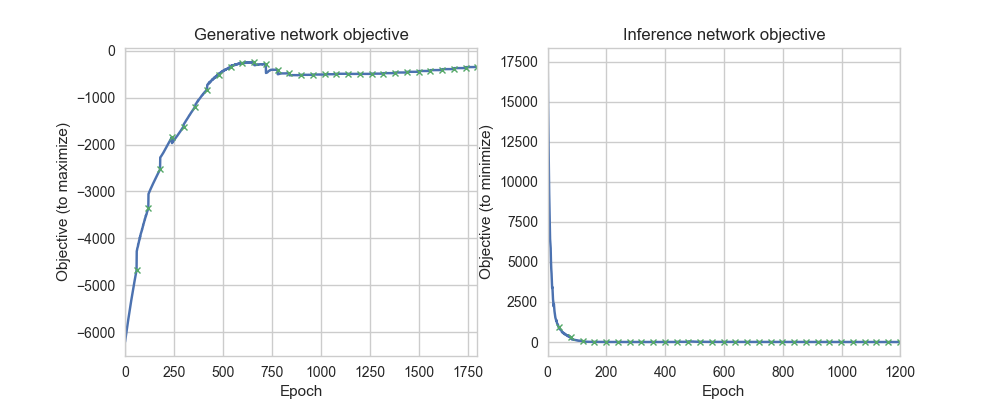

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)
ax[0].plot(
    np.arange(len(generative_network_objective)),
    np.nan_to_num(generative_network_objective)
)
ax[0].plot(
    np.cumsum(num_generative_epochs) - 1,
    np.nan_to_num(np.array(generative_network_objective)[np.cumsum(num_generative_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[0].set_xlim([0, len(generative_network_objective) - 1])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Objective (to maximize)')
ax[0].set_title('Generative network objective')

ax[1].plot(
    np.arange(len(inference_network_objective)),
    np.nan_to_num(inference_network_objective)
)
ax[1].plot(
    np.cumsum(num_inference_epochs) - 1,
    np.nan_to_num(np.array(inference_network_objective)[np.cumsum(num_inference_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[1].set_xlim([0, len(inference_network_objective) - 1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Objective (to minimize)')
ax[1].set_title('Inference network objective')

fig.savefig('./figures/training.pdf', bbox_inches='tight')

# Testing the Generative Model

<IPython.core.display.Javascript object>


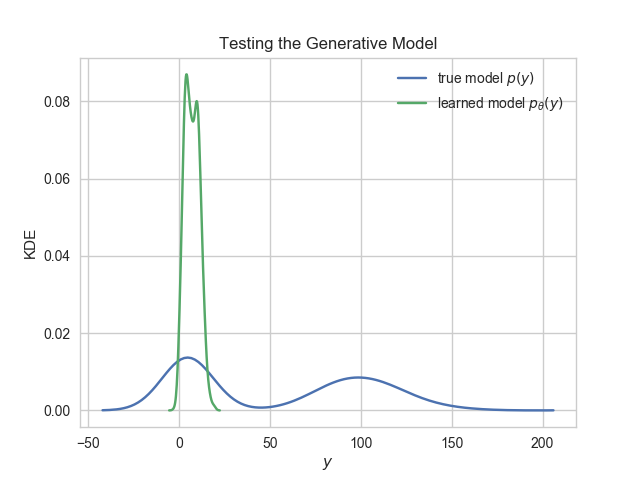

In [8]:
fig, ax = plt.subplots()
num_data = 1000

# generative_model = quadratic.GenerativeModel()
_, _, y = generative_model.sample(num_data)
y = y.squeeze(1).numpy()
sns.kdeplot(y, ax=ax, label='true model $p(y)$')

_, _, y = generative_network.sample(num_data)
y = y.squeeze(1).numpy()
sns.kdeplot(y, ax=ax, label='learned model $p_{\\theta}(y)$')

ax.set_ylabel('KDE')
ax.set_xlabel('$y$')
ax.set_title('Testing the Generative Model')

fig.savefig('./figures/generative.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


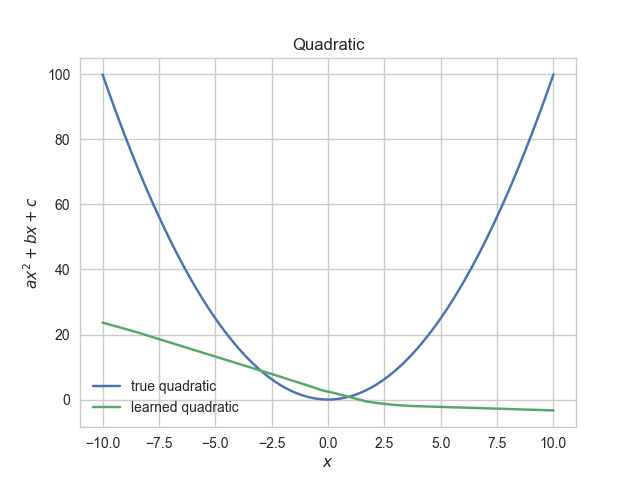

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1)
true_quadratic = generative_model.f(torch.zeros(100), torch.linspace(-10, 10, 100)).numpy()


learned_quadratic = generative_network.f_approx(
    Variable(torch.zeros(100, 1)), 
    Variable(torch.linspace(-10, 10, 100).unsqueeze(-1))
).data.numpy()
ax.plot(np.linspace(-10, 10, 100), true_quadratic, label='true quadratic')
ax.plot(np.linspace(-10, 10, 100), learned_quadratic, label='learned quadratic')
ax.set_xlabel('$x$')
ax.set_ylabel('$ax^2 + bx + c$')
ax.set_title('Quadratic')
ax.legend()

fig.savefig('./figures/quadratic.pdf', bbox_inches='tight')

# Testing Inference

In [10]:
_, _, y_test = generative_model.sample(1)
y_test = generative_model.sample(1)[2][0][0]
y_test = 25

<IPython.core.display.Javascript object>


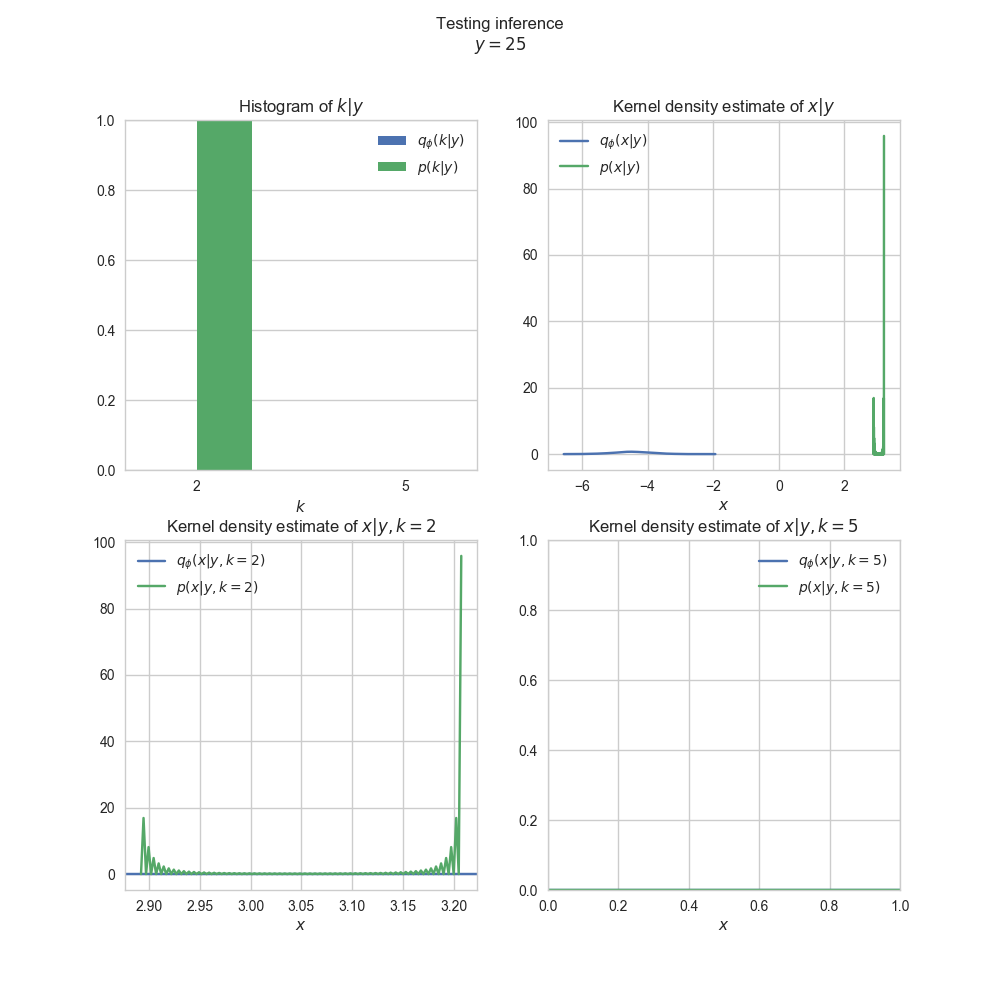

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Testing inference\n$y = {}$'.format(y_test))
bar_width = 0.8

##############
##############
##############

num_inference_network_samples = 1000
y = torch.Tensor([[y_test]]).expand(num_inference_network_samples, 1)
k, x = inference_network.sample(y)

values = [2, 5]
normalized_weights = [
    torch.sum(k == 2) / len(k),
    torch.sum(k == 5) / len(k),
]
bar1 = ax[0][0].bar(np.array(values) - bar_width / 2, normalized_weights, width=bar_width, tick_label=values, color=colors[0], label='$q_{\phi}(k | y)$')
sns.kdeplot(x.view(-1).numpy(), ax=ax[0][1], label='$q_{\phi}(x | y)$', color=colors[0])

if len(x[k == 2]) != 0:
    sns.kdeplot(x[k == 2].view(-1).numpy(), ax=ax[1][0], label='$q_{\phi}(x | y, k = 2)$', color=colors[0])
else:
    ax[1][0].axhline(0, label='$q_{\phi}(x | y, k = 2)$', color=colors[0])

if len(x[k == 5]) != 0:
    sns.kdeplot(x[k == 5].view(-1).numpy(), ax=ax[1][1], label='$q_{\phi}(x | y, k = 5)$', color=colors[0])
else:
    ax[1][1].axhline(0, label='$q_{\phi}(x | y, k = 5)$', color=colors[0])

##############
##############
##############

num_particles = 1000
num_posterior_samples = 1000
k, x = generative_model.importance_sample(y_test, num_particles, resample=True, num_resample=num_posterior_samples)

values = [2, 5]
normalized_weights = [
    sum(k == 2) / len(k),
    sum(k == 5) / len(k),
]
bar2 = ax[0][0].bar(np.array(values) + bar_width / 2, normalized_weights, tick_label=values, label='$p(k | y)$', color=colors[1])

sns.distplot(x.numpy(), hist=False, ax=ax[0][1], label='$p(x | y)$', color=colors[1])

if normalized_weights[0] != 0:
    sns.distplot(
        x[k == 2].numpy(), 
        hist=False,
        ax=ax[1][0],
        label='$p(x | y, k = 2)$',
        color=colors[1]
    )
else:
    ax[1][0].axhline(0, label='$p(x | y, k = 2)$', color=colors[1])

if normalized_weights[1] != 0:
    sns.distplot(
        x[k == 5].numpy(), 
        hist=False,
        ax=ax[1][1],
        label='$p(x | y, k = 5)$',
        color=colors[1]
    )
else:
    ax[1][1].axhline(0, label='$p(x | y, k = 5)$', color=colors[1])

##############
##############
##############

ax[0][0].set_xticks(np.array([2, 5]))
ax[0][0].xaxis.grid(False)
ax[0][0].set_ylim([0, 1])
ax[0][0].set_title('Histogram of $k | y$')
ax[0][0].set_xlabel('$k$')
ax[0][0].legend()

ax[0][1].set_title('Kernel density estimate of $x | y$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $x | y, k = 2$')
ax[1][0].set_xlabel('$x$')

ax[1][1].set_title('Kernel density estimate of $x | y, k = 5$')
ax[1][1].set_xlabel('$x$')
ax[1][1].legend()

fig.savefig('./figures/inference.pdf', bbox_inches='tight')